In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good
3,5637,3392,4,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,Good
4,5638,3392,5,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,Good


In [4]:
df.shape

(100000, 28)

In [5]:
df['Credit_Score'].value_counts()/df.shape[0] 

Standard    0.53174
Poor        0.28998
Good        0.17828
Name: Credit_Score, dtype: float64

Multiclass, somewhat imbalanced, especially the important Good class

In [6]:
def data_preprocessor(df):
    todrop = ['ID','Customer_ID','Name','SSN','Type_of_Loan','Month','Credit_Utilization_Ratio','Monthly_Inhand_Salary','Occupation']
    enc_credmix = {'Bad':0.0,'Standard':0.5,'Good':1.0}
    df['Credit_Mix']=df['Credit_Mix'].replace(enc_credmix)

    enc_paymin = {'No':0.0,'NM':0.5,'Yes':1.0}
    df['Payment_of_Min_Amount']=df['Payment_of_Min_Amount'].replace(enc_paymin)
    return df.drop(todrop,axis=1)

In [7]:
df = data_preprocessor(df)

In [8]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='O').columns.tolist()
cat_cols.remove('Credit_Score')

cat_cols.append('Credit_Mix')
cat_cols.append('Payment_of_Min_Amount')
num_cols.remove('Credit_Mix')
num_cols.remove('Payment_of_Min_Amount')

# Visualizing the Features

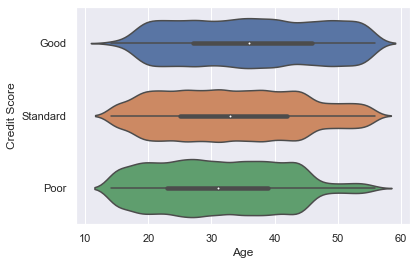

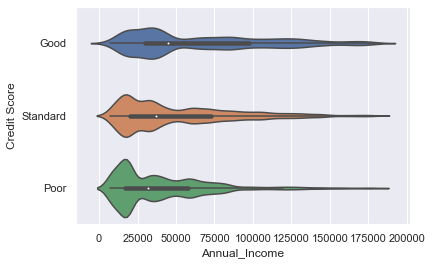

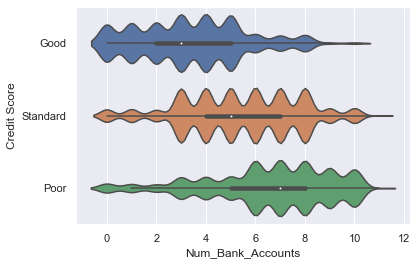

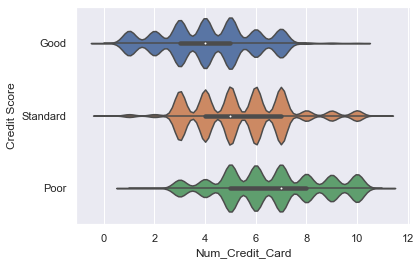

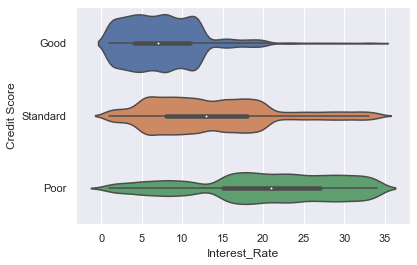

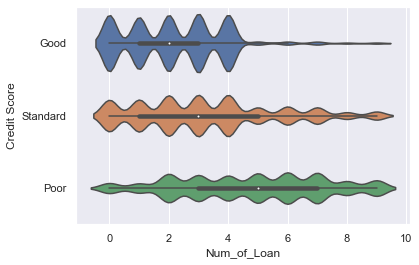

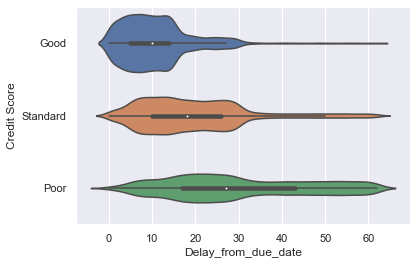

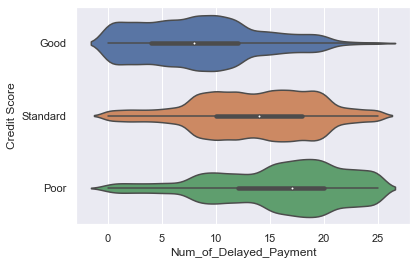

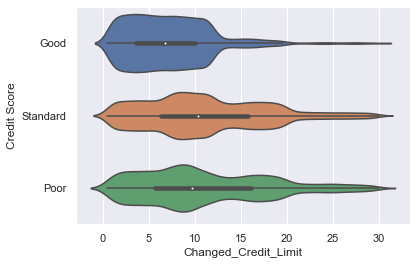

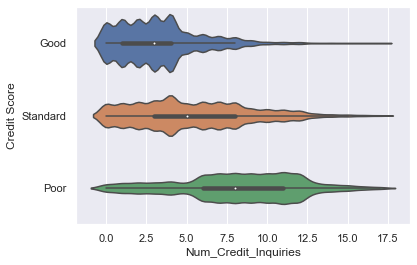

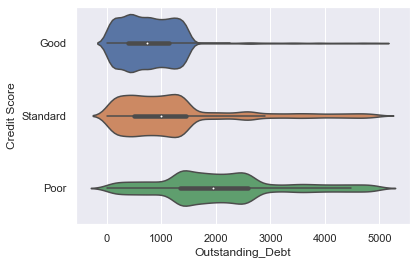

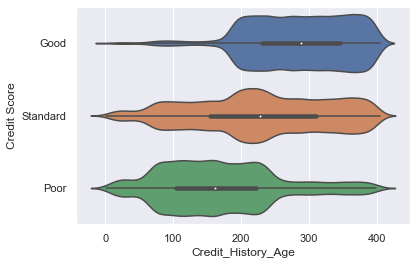

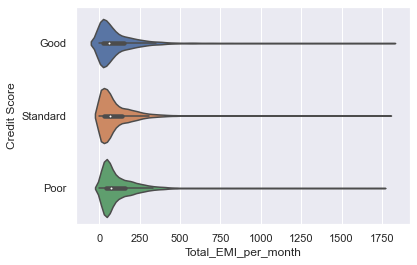

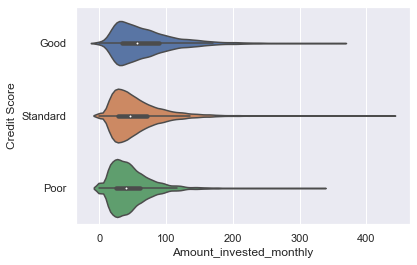

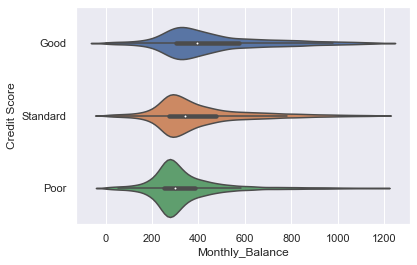

In [9]:
for i in num_cols:
    sns.violinplot(data=df,x=i,y='Credit_Score',alpha=0.6)
    plt.ylabel('Credit Score')
    plt.xlabel(i)
    plt.show()

Just by looking at the distribution, the following look pretty non-predictive, and we're going to drop them:<br>
'Month','Credit_Utilization_Ratio'

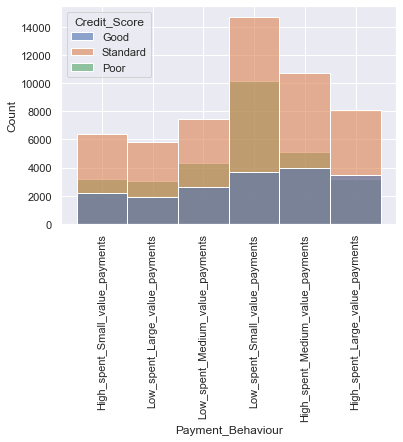

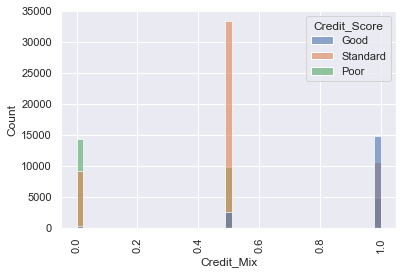

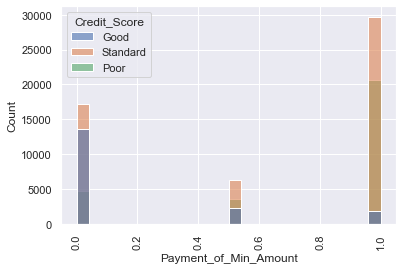

In [10]:
for i in cat_cols:
    sns.histplot(data=df,x=i,hue='Credit_Score',alpha=0.6)
    plt.xlabel(i)
    plt.xticks(rotation=90)
    plt.show()

'Occupation' - drop this. Too many categories and looks pretty non-predictive. Almost equal proportion of classes in all occupations.<br>
'Credit_Mix' - make this a linear scale: Bad=0.0,Standard=0.5,Good=1.0<br>
'Payment_of_Min_Amount' - make this a linear scale: No: 0.0, NM = 0.5, Yes: 1.0<br>
'Payment_Behaviour' - no choice but to make it one hot<br>

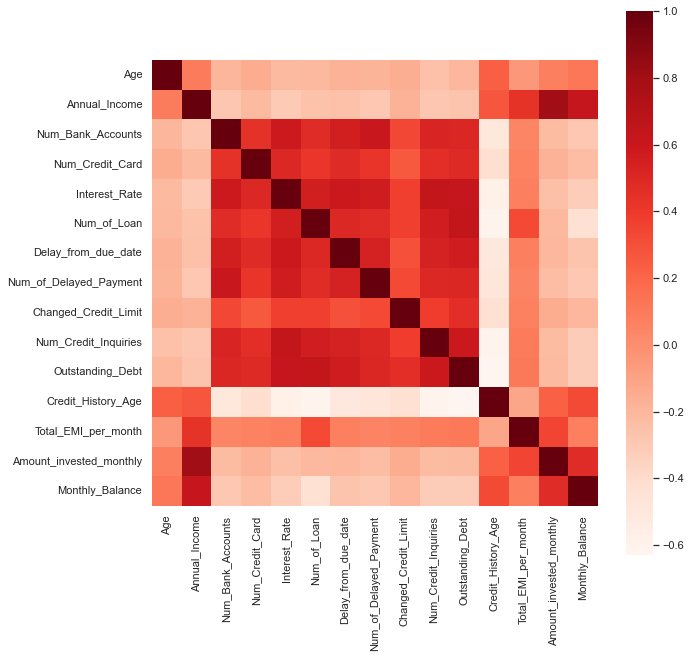

In [11]:
corr = df[num_cols].corr()
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,square=True,cmap='Reds',cbar=True)
plt.show()

There appear to be 2 blocks of features which have a fair amount of correlation amongst themselves, as illustrated below. I think it might be better to do PCA to reduce the number of features some more.

In [12]:
num_cols1 = ['Age','Annual_Income','Credit_History_Age','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance']
num_cols2 = list(set(num_cols)-set(num_cols1))

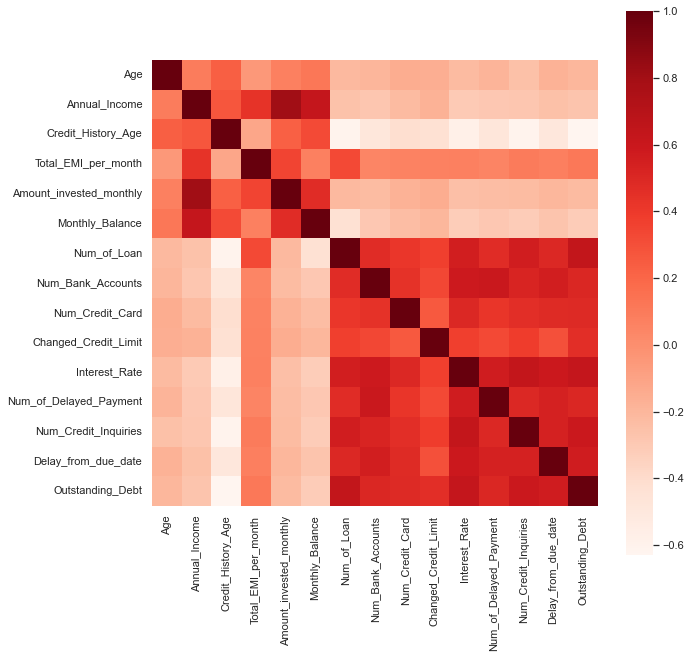

In [13]:
corr = df[num_cols1+num_cols2].corr()
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,square=True,cmap='Reds',cbar=True)
plt.show()

# Preparing the Dataset for Model Fitting
We'll scale the data using MinMaxScaler and perform PCA to reduce dimensions (explain 99% of variance).

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

trainX, testX, trainY, testY = train_test_split(df.drop('Credit_Score',axis=1),df['Credit_Score'],test_size=0.2,random_state=2)

In [15]:
def encode_y(y):
    enc_y = {'Good':0,'Standard':1,'Poor':2}
    return y.replace(enc_y).to_numpy()

y_train = encode_y(trainY)
y_test = encode_y(testY)

In [16]:
trainX_num = trainX[num_cols]
trainX_cat = trainX[['Credit_Mix','Payment_of_Min_Amount']]
trainX_ohe = trainX['Payment_Behaviour']

scaler = MinMaxScaler()
scaler.fit(trainX_num)

ohe = OneHotEncoder()
ohe.fit(trainX_ohe.values.reshape(-1,1))

OneHotEncoder()

In [17]:
trainX_num = scaler.transform(trainX_num)

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(n_components=0.99)
pca.fit(trainX_num)
print(pca.components_.shape) #we're getting a two component reduction, which is not bad

(13, 15)


In [20]:
def data_transformer(X):
    X_num = X[num_cols]
    X_cat = X[['Credit_Mix','Payment_of_Min_Amount']]
    X_ohe = X['Payment_Behaviour']
  
    X_num = scaler.transform(X_num)
    X_num = pca.transform(X_num)
    X_cat = X_cat.to_numpy()
    X_ohe = ohe.transform(X_ohe.values.reshape(-1,1)).toarray()
    
    return np.concatenate((X_num,X_cat,X_ohe),axis=1)

In [21]:
X_train = data_transformer(trainX)
X_test = data_transformer(testX)

# Model Fitting

In [22]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

C:\Users\dasab\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [23]:
classifiers = [GaussianNB(), DecisionTreeClassifier(),
               LGBMClassifier(), CatBoostClassifier(verbose=False)]

scores = pd.DataFrame(columns=['Classifier','TestScore','TrainScore','TestConfusionMatrix'])

for i in classifiers:
    i.fit(X_train, y_train)
    y_pred_test = i.predict(X_test)
    y_pred_train = i.predict(X_train)
    test_score = accuracy_score(y_test, y_pred_test)
    train_score = accuracy_score(y_train, y_pred_train)
    cm = confusion_matrix(y_test,y_pred_test,normalize='true')
    scores.loc[len(scores.index)] = [i.__class__.__name__,test_score,train_score,cm]

In [24]:
scores.drop(['TestConfusionMatrix'],axis=1).sort_values(by='TestScore')

,Classifier,TestScore,TrainScore
0,GaussianNB,0.65075,0.647663
1,DecisionTreeClassifier,0.70330,1.000000
2,LGBMClassifier,0.73100,0.753337
3,CatBoostClassifier,0.75355,0.794775


Target Encoding: 
0 - Good (18% in dataset), 1 - Standard (29% in dataset), 2 - Poor (53% in dataset)
Confusion Matrices are normalized along the rows. The diagonals represent recall scores of that row.



[]

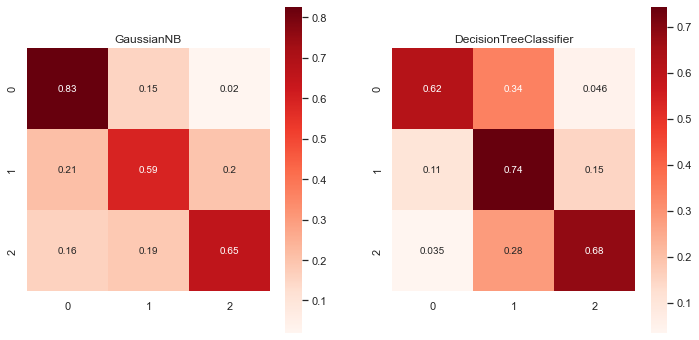

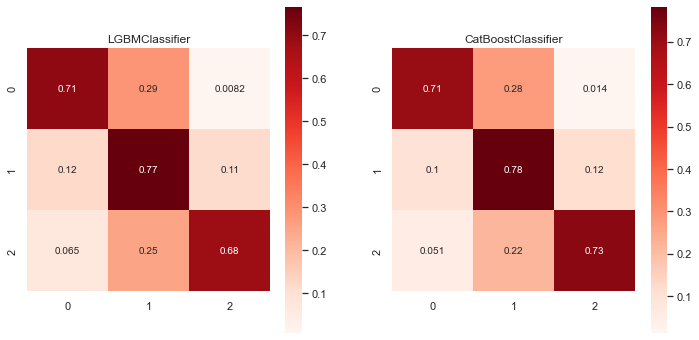

In [25]:
print("Target Encoding: ")
print("0 - Good (18% in dataset), 1 - Standard (29% in dataset), 2 - Poor (53% in dataset)")
print("Confusion Matrices are normalized along the rows. The diagonals represent recall scores of that row.\n")

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
sns.heatmap(scores.loc[0,'TestConfusionMatrix'],cmap='Reds',square=True,cbar=True,annot=True,ax=ax1)
ax1.set_title(scores.loc[0,'Classifier'])
sns.heatmap(scores.loc[1,'TestConfusionMatrix'],cmap='Reds',square=True,cbar=True,annot=True,ax=ax2)
ax2.set_title(scores.loc[1,'Classifier'])
plt.plot()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
sns.heatmap(scores.loc[2,'TestConfusionMatrix'],cmap='Reds',square=True,cbar=True,annot=True,ax=ax1)
ax1.set_title(scores.loc[2,'Classifier'])
sns.heatmap(scores.loc[3,'TestConfusionMatrix'],cmap='Reds',square=True,cbar=True,annot=True,ax=ax2)
ax2.set_title(scores.loc[3,'Classifier'])
plt.plot()

### Fitting a Neural Network Model as an exercise

In [26]:
#Lets try to fit a NN 
import torch
import torch.nn as nn

In [27]:
from sklearn.preprocessing import OneHotEncoder

ohe_y = OneHotEncoder()
ohe_y.fit(trainY.values.reshape(-1,1))

def y_to_ohe(y):
    return ohe_y.transform(y.values.reshape(-1,1)).toarray()

In [28]:
trainsetX, validX, trainsetY, validY = train_test_split(trainX,trainY,test_size=0.2,random_state=2)

In [29]:
y_train_ohe = y_to_ohe(trainsetY)
y_valid_ohe = y_to_ohe(validY)
y_test_ohe = y_to_ohe(testY)

In [30]:
def data_transformer2(X):
    X_num = X[num_cols]
    X_cat = X[['Credit_Mix','Payment_of_Min_Amount']]
    X_ohe = X['Payment_Behaviour']
  
    X_num = scaler.transform(X_num)
    X_num = pca.transform(X_num)
    X_cat = X_cat.to_numpy()
    X_ohe = ohe.transform(X_ohe.values.reshape(-1,1)).toarray()
    
    
    return np.concatenate((X_num,X_cat,X_ohe),axis=1)

In [31]:
X_train = data_transformer2(trainsetX)
X_valid = data_transformer2(validX)
X_test = data_transformer2(testX)

In [32]:
def to_tensor(X,y):
    Xt = torch.from_numpy(X).to(torch.float)
    yt = torch.from_numpy(y).to(torch.float)
    return Xt, yt

Xt_train, yt_train = to_tensor(X_train, y_train_ohe)
Xt_valid, yt_valid = to_tensor(X_valid, y_valid_ohe)
Xt_test, yt_test = to_tensor(X_test, y_test_ohe)

In [33]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layers = nn.Sequential(nn.Linear(21,50), nn.ReLU(),
                                    nn.Linear(50,10), nn.ReLU(),
                                    nn.Linear(10,3), nn.Softmax(dim=1))
        
    def forward(self,x):
        return self.layers(x)
    
def train(model, n_epoch, patience, lr, X_train, X_valid, y_train, y_valid):
    
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    printstep = int(n_epoch/10)
    
    last_loss = 100.
    trigger = 0
    
    epoch_loss_train = list()
    epoch_loss_valid = list()
    
    for epoch in range(1,n_epoch+1):
        
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss = criterion(y_pred_train,y_train)
        loss.backward()
        optimizer.step()
        
        if(epoch%printstep == 0):
            print("Epoch {}, Loss {}".format(epoch,loss.item()))
        
        #early stopping
        y_pred_valid = model(X_valid)
        loss_valid = criterion(y_pred_valid,y_valid)
        new_loss = loss_valid.item()
        epoch_loss_train.append(loss.item())
        epoch_loss_valid.append(new_loss)
        
        if(new_loss > last_loss):
            trigger += 1
            if(trigger > patience):
                print("Early Stopping at Epoch {}".format(epoch))
                break
        else:
            trigger = 0
        last_loss = new_loss
        
    plt.plot(epoch_loss_train)
    plt.plot(epoch_loss_valid)
    plt.legend(['Training Loss','Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    return model

def model_prediction(X):
    y = model(X).detach().numpy()
    return np.argmax(y,axis=1)

def model_accuracy(X,y):
    y_pred = model_prediction(X)
    return accuracy_score(y,y_pred)

def model_cm(X,y):
    y_pred = model_prediction(X)
    return confusion_matrix(y,y_pred,normalize='true')
    
def model_scores(X,y):
    y = np.argmax(y,axis=1)
    print("Accuracy: %s"%model_accuracy(X,y))
    cm = model_cm(X,y)
    sns.heatmap(cm,cmap='Reds',square=True,cbar=True,annot=True)
    plt.title("Confusion Matrix. Normalized (Diagonals represent recall)")
    plt.plot()

Epoch 150, Loss 0.9268665909767151
Epoch 300, Loss 0.8798539042472839
Epoch 450, Loss 0.856399416923523
Epoch 600, Loss 0.8472560048103333
Epoch 750, Loss 0.8430134057998657
Epoch 900, Loss 0.8406335711479187
Epoch 1050, Loss 0.8389943838119507
Epoch 1200, Loss 0.837665319442749
Epoch 1350, Loss 0.8364426493644714
Epoch 1500, Loss 0.8352583646774292


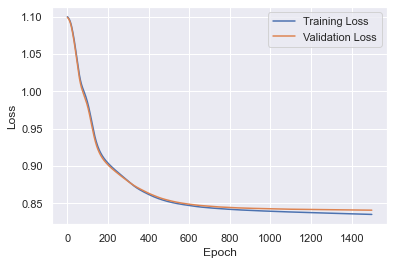

Test Set
Accuracy: 0.70645


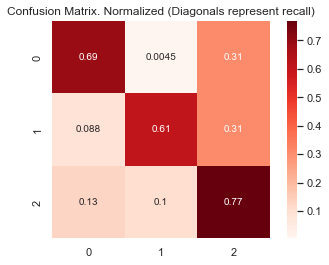

In [34]:
n_epoch = 1500
patience = 2
lr = 0.001

model = NN()
model = train(model, n_epoch, patience, lr, Xt_train, Xt_valid, yt_train, yt_valid)

print("Test Set")
model_scores(Xt_test, yt_test)

Model performance is similar to the ML models. I think its better to stick with one of those. Depending on need (predicting which class more accurately), one can select and fine-tune one of those models.